<h2>Capstone Project - Final Report</h2>

<h2>1. Introduction</h2>

<h3>1.1 Problem Description</h3>

Following the second suggestion, I will use the data from Foursquare to analyze the different types of businesses in the city of Cuenca, Ecuador.  This is a small city, essentially a tourist destination due to its denomination as Cultural Heritage of Humanity, in addition to its beautiful spanish colonial architecture. 
Cuenca is visited by a large number of people from different parts of the world. Of course, at this time all tourist activities are suspended by the coronavirus health crisis. 
But after that, I am very sure that there will be new kinds of opportunities available for this beautiful city to attract new visitors from the world.
Therefore, the objective will be to find the different types of restaurants and food places by categories and show their ranking, an the areas were they are most located.  With this information could guide to local investors to find new areas and places in the city to establish new business opportunities.

<h2>2. Data Section</h2>

<h3>2.1 Description of the data</h3>

The city of Cuenca is divided into neighborhoods, currently it has 15 neighborhoods, all with different land uses and established restaurants throughout the city.  I will use the geographical location of the latitude and longitude of the neighborhoods to send inquiries to the Foursquare service to explore all the places in each neighborhood.  After that, I will use the Foursquare ratings to determine wich categories are the best qualifyed and where are located in each neighborhood.  
This will be great information to find out the preferred place in different neighborhoods and will serve restaurant owners to find possible new places to open branches. 

<h3>2.2 Data source</h3>

The data to be used will be the list of neighborhoods "parroquias" in spanish, publicly available on the local government site of the "Municipalidad de Cuenca" located at http://ide.cuenca.gob.ec/geoportal-web/viewer.jsf in the section "Parroquias Urbanas".
Using the Google Maps geocoding page https://developers.google.com/maps/documentation/geocoding/intro?hl=es-419. I will make a csv file that contains the name of the 15 neighborhoods, as well as the latitude and longitude of each one.

               name	            lat             	lng
    0           Bellavista       -2.881293       -79.005168
    1           San Blas         -2.900793       -78.999998
    2           Sucre            -2.901130       -79.015505
    . . . 

With this information, I will send inquiries to the Foursquare service, using a function to explore each neighborhood in a 1000 meters radius, as we practice in the corresponding laboratories.

    limit = 100
    radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, -2.881293, -79.005168, VERSION, radius, limit)

I will create a data frame to filter by categories and use all the places that include the words: restaurant, food, coffee shop, fast food, or something similar related to the food business.
Once the information is filtered with related places, it will be necessary to present it on a map.  
Continuing with the data analisys, once I get the venues related to food bussiness, will use again the Foursquare information to get the Rating value for each of the food venues.
This will be accomplish with a new function to send inquiries to Foursqueare using the venue id and get the rating.  Then it will be merged to the original food venues dataframe.

 venue_id = '50784860e4b06b24d94043af'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

Once that the rating is in the dataframe I will clustering the venues using the mean of the rating, with this information our investments will get a big picture about the best ranking places and the location of it on Cuenca, Ecuador.
This cluster will be presented on a Map grouped by the different levels of the cluster with their respective rating.

First import all the needed dependencies

In [2]:
import requests
import pandas as pd 
import numpy as np 
import random
from geopy.geocoders import Nominatim
from IPython.display import Image 
from IPython.core.display import HTML     
from pandas.io.json import json_normalize
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

Assign credentials to use with Foursquare Service

In [3]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = ''
LIMIT = '100'

CSV file with the "parroquias" names and coordinates 

In [4]:
file_name='ParroquiasUrbanasCuenca_GeoLoc.csv'
cuenca_neighborhood=pd.read_csv(file_name)

Convert the csv file to DataFrame

In [5]:
cuenca_neighborhood.head()

,name,lat,lng
0,Bellavista,-2.881293,-79.005168
1,San Sebastián,-2.890083,-79.026364
2,El Batán,-2.896284,-79.033429
3,Yanuncay,-2.915857,-79.027777
4,Sucre,-2.901130,-79.015505


Function to get nearby places around the center of each neighborhood

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Parroquia',
                  'Parroquia Latitude',
                  'Parroquia Longitude',
                  'Venue',
                  'Id',
                  'Latitude', 
                  'Longitude', 
                  'Category']
    
    return(nearby_venues)

Process the function using the neighborhood dataframe as input parameters

In [7]:
cuenca_venues = getNearbyVenues(names=cuenca_neighborhood['name'],
                                   latitudes=cuenca_neighborhood['lat'],
                                   longitudes=cuenca_neighborhood['lng']
                                  )

Bellavista
San Sebastián
El Batán
Yanuncay
Sucre
El Sagrario
Huayna-Capac
Gil Ramírez Dávalos
San Blas
Cañaribamba
El Vecino
Hermano Miguel
Totoracocha
Machángara
Monay


In [8]:
cuenca_venues.shape

(279, 8)

Clean the duplicated data

In [9]:
cuenca_venues.drop_duplicates(subset ="Venue", inplace = True)

In [10]:
cuenca_venues.head()

,Parroquia,Parroquia Latitude,Parroquia Longitude,Venue,Id,Latitude,Longitude,Category
0,Bellavista,-2.881293,-79.005168,"Picantes De Leo, Bellavista",50784860e4b06b24d94043af,-2.888823,-79.006569,Seafood Restaurant
1,Bellavista,-2.881293,-79.005168,Fybeca,4f660ce2e4b08b4770d62b31,-2.883704,-79.003730,Pharmacy
2,Bellavista,-2.881293,-79.005168,kuna hotel,52fcde73498e44aedeafa615,-2.884541,-79.002080,Hotel
3,Bellavista,-2.881293,-79.005168,Viko,505f554fe4b018ec7b9fd22b,-2.886314,-79.008958,Fried Chicken Joint
4,Bellavista,-2.881293,-79.005168,Super949,4b9bbdecf964a520fa1f36e3,-2.889759,-79.002753,Music Venue


In [11]:
cuenca_venues.shape

(181, 8)

Filter places related to the food business exclusively

In [12]:
cuenca_food = cuenca_venues[cuenca_venues['Category'].str.contains('Restaurant|Joint|BBQ|Food|Place|Bar|Steakhouse|Pub|Bistro|Gastro|caf|coff')].reset_index(drop=True)

In [13]:
cuenca_food.drop(['Parroquia Latitude','Parroquia Longitude'], axis=1, inplace=True)
cuenca_food.head()

,Parroquia,Venue,Id,Latitude,Longitude,Category
0,Bellavista,"Picantes De Leo, Bellavista",50784860e4b06b24d94043af,-2.888823,-79.006569,Seafood Restaurant
1,Bellavista,Viko,505f554fe4b018ec7b9fd22b,-2.886314,-79.008958,Fried Chicken Joint
2,San Sebastián,El Rincon De Lucas,4e6eb68eb9933190ed2dd97c,-2.889131,-79.033295,Hot Dog Joint
3,San Sebastián,Unagi Teppanyaki & sushibar,4f1b7702e4b08382322fb6c2,-2.891627,-79.019083,Sushi Restaurant
4,San Sebastián,BQ Sport,4df304f6d4c01ff6b2eb0650,-2.891020,-79.026107,Restaurant


In [14]:
cuenca_food.shape

(85, 6)

Function to obtain the rating of each food business place

In [15]:
def getRatingVenues(n_venue, v_id):
    
    rvenues_list=[]
    for name, venue_id in zip(n_venue, v_id):
        #print(name)
        
        try:
            url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
            
            results = requests.get(url).json()
            rat = results['response']['venue']['rating']
        except:
            rat = 'n/a'
            
        rvenues_list.append([(name, venue_id,
        rat)])
        
    rating_venues = pd.DataFrame([item for rvenue_list in rvenues_list for item in rvenue_list])
    rating_venues.columns = ['Venue','Id','Rating']
    
    return(rating_venues)

Process the function using the Venue and Id parameters.

In [16]:
rcuenca_food = getRatingVenues(n_venue=cuenca_food['Venue'],v_id=cuenca_food['Id'])

As we can see, some of the places are not yet rated, so we must apply some solution for these values.

In [17]:
rcuenca_food.head()

,Venue,Id,Rating
0,"Picantes De Leo, Bellavista",50784860e4b06b24d94043af,7.4
1,Viko,505f554fe4b018ec7b9fd22b,n/a
2,El Rincon De Lucas,4e6eb68eb9933190ed2dd97c,8.2
3,Unagi Teppanyaki & sushibar,4f1b7702e4b08382322fb6c2,7.1
4,BQ Sport,4df304f6d4c01ff6b2eb0650,6.3


In [18]:
rcuenca_food.shape

(85, 3)

Proceed to merge the dataframe with the new rate information into the existing dataframe.  The result is a dataframe with seven columns.

In [19]:
cuenca_food = pd.merge(cuenca_food,rcuenca_food[['Id','Rating']],on='Id', how='left')
cuenca_food.shape

(85, 7)

Replace the n/a value for a numpy nan value

In [20]:
cuenca_food.replace("n/a", np.nan, inplace = True)

And now replace the numpy nan value with the mean of the Rating column 

In [21]:
avg_Rating=cuenca_food['Rating'].astype('float').mean(axis=0)
cuenca_food['Rating'].replace(np.nan, round(avg_Rating, 1), inplace=True)

Now all the places have a rating value

In [22]:
cuenca_food.head()

,Parroquia,Venue,Id,Latitude,Longitude,Category,Rating
0,Bellavista,"Picantes De Leo, Bellavista",50784860e4b06b24d94043af,-2.888823,-79.006569,Seafood Restaurant,7.4
1,Bellavista,Viko,505f554fe4b018ec7b9fd22b,-2.886314,-79.008958,Fried Chicken Joint,7.5
2,San Sebastián,El Rincon De Lucas,4e6eb68eb9933190ed2dd97c,-2.889131,-79.033295,Hot Dog Joint,8.2
3,San Sebastián,Unagi Teppanyaki & sushibar,4f1b7702e4b08382322fb6c2,-2.891627,-79.019083,Sushi Restaurant,7.1
4,San Sebastián,BQ Sport,4df304f6d4c01ff6b2eb0650,-2.891020,-79.026107,Restaurant,6.3


In [24]:
cuenca_food.to_csv('cuenca_food.csv')

Obtain the geo position for the Cuenca City to create a folium map, using all the venues with the corresponding Rating, Category, Vanue name, latitude and longitude.

In [22]:
address = 'Cuenca, Azuay, Ecuador'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [23]:
# create map
map_cuenca = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to the map
for lat, lng, label, categorie, rating in zip(cuenca_food['Latitude'], 
                                              cuenca_food['Longitude'], 
                                              cuenca_food['Venue'], 
                                              cuenca_food['Category'],
                                              cuenca_food['Rating']):
    label = folium.Popup(str(label) + ' Categoria: '+ str(categorie) + ' Rating: '+ str(rating), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_cuenca)
       
map_cuenca

Define five clusters to group the venues by rating and map them.

In [24]:
kclusters = 5
cuenca_food_clustering = cuenca_food.drop(['Parroquia','Venue','Id','Latitude','Longitude','Category'], 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cuenca_food_clustering)
kmeans.labels_[0:10]
cuenca_food.insert(0, 'Cluster Labels', kmeans.labels_)

In [26]:
map_cuenca_cluster = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, label, categorie, rating, cluster in zip(cuenca_food['Latitude'], 
                                              cuenca_food['Longitude'], 
                                              cuenca_food['Venue'], 
                                              cuenca_food['Category'],
                                              cuenca_food['Rating'],
                                              cuenca_food['Cluster Labels']):
    label = folium.Popup(str(label) + ' Categoria: '+ str(categorie) + ' Rating: '+ str(rating)+ ' Cluster: '+str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_cuenca_cluster)
       
map_cuenca_cluster

The clusters are grouping the food venues by the rating, then we use the cluster number 3 wich have the most higher qualification.

In [27]:
cuenca_food.loc[cuenca_food['Cluster Labels'] == 0, cuenca_food.columns[[2] + list(range(4, cuenca_food.shape[1]))]]

,Venue,Latitude,Longitude,Category,Rating
2,El Rincon De Lucas,-2.889131,-79.033295,Hot Dog Joint,8.2
7,Restaurante El Campo,-2.895165,-79.036770,Restaurant,7.8
10,Rancho's Burger,-2.903867,-79.013541,Burger Joint,8.2
11,La Fornace,-2.898287,-79.017990,Italian Restaurant,8.1
16,Esquina De Las Artes,-2.901027,-79.008073,Latin American Restaurant,8.1
29,Guajibamba,-2.893709,-79.003156,Latin American Restaurant,8.0
31,Bauhouse Hostel & Bar,-2.895530,-79.004594,Bar,7.9
32,Trattoria Novecento,-2.897890,-79.002783,Italian Restaurant,7.9
36,Tiestos Cafe Restaurante,-2.900058,-79.003521,Steakhouse,8.1
39,Jazz Society Café,-2.900053,-79.004552,Bar,7.8


In [28]:
cuenca_food.loc[cuenca_food['Cluster Labels'] == 1, cuenca_food.columns[[2] + list(range(4, cuenca_food.shape[1]))]]

,Venue,Latitude,Longitude,Category,Rating
3,Unagi Teppanyaki & sushibar,-2.891627,-79.019083,Sushi Restaurant,7.1
8,Cristo del Consuelo,-2.895363,-79.035703,Food,7.2
9,la parrilla de hector,-2.921660,-79.022988,BBQ Joint,6.7
18,Habana Vieja,-2.904223,-79.014460,Caribbean Restaurant,7.1
22,Pappardelle Ristorante,-2.905285,-79.011895,Italian Restaurant,7.1
23,Miso,-2.904255,-79.008829,Restaurant,7.2
24,Oro Mar,-2.896173,-79.012350,Seafood Restaurant,7.0
25,La Parrillada,-2.905594,-79.009499,Steakhouse,6.9
40,La Pergola,-2.890469,-79.004801,Restaurant,7.1
41,Pizza House,-2.898667,-78.998710,Pizza Place,7.1


In [29]:
cuenca_food.loc[cuenca_food['Cluster Labels'] == 2, cuenca_food.columns[[2] + list(range(4, cuenca_food.shape[1]))]]

,Venue,Latitude,Longitude,Category,Rating
0,"Picantes De Leo, Bellavista",-2.888823,-79.006569,Seafood Restaurant,7.4
1,Viko,-2.886314,-79.008958,Fried Chicken Joint,7.5
6,La Taberna,-2.891445,-79.021006,Food & Drink Shop,7.5
12,Orange Original Food Remigio,-2.902367,-79.013591,Wings Joint,7.5
13,La Herradura,-2.903816,-79.012646,Steakhouse,7.7
15,Los Molinos del Batán,-2.897627,-79.012956,Restaurant,7.5
19,La Parihuela,-2.901783,-79.008563,Seafood Restaurant,7.5
20,Pizza Hut,-2.906320,-79.009441,Pizza Place,7.7
21,El Arriero,-2.900275,-79.022117,BBQ Joint,7.4
28,El Puerto Marisquería,-2.901567,-79.008598,Seafood Restaurant,7.5


In [30]:
cuenca_food.loc[cuenca_food['Cluster Labels'] == 3, cuenca_food.columns[[2] + list(range(4, cuenca_food.shape[1]))]]

,Venue,Latitude,Longitude,Category,Rating
14,Mangiare Bene,-2.895692,-79.009809,Italian Restaurant,8.8
17,Noé sushi bar,-2.907668,-79.009867,Sushi Restaurant,8.4
30,Fabianos,-2.899702,-79.001052,Pizza Place,8.5
33,Tiestos,-2.900844,-79.001314,South American Restaurant,8.7
45,El Charrua,-2.911503,-79.006685,BBQ Joint,8.8
52,Mediterraneo,-2.901106,-79.004264,Italian Restaurant,8.9
54,El Mercado Cuenca,-2.901356,-79.005226,Comfort Food Restaurant,8.8
78,Rancho Chileno,-2.889141,-78.986598,Restaurant,8.5


In [31]:
cuenca_food.loc[cuenca_food['Cluster Labels'] == 4, cuenca_food.columns[[2] + list(range(4, cuenca_food.shape[1]))]]

,Venue,Latitude,Longitude,Category,Rating
4,BQ Sport,-2.891020,-79.026107,Restaurant,6.3
5,Local 5,-2.889180,-79.033200,American Restaurant,6.1
26,John's Burger,-2.902962,-79.019854,Burger Joint,6.4
27,Restaurant El Tequila,-2.892909,-79.016054,South American Restaurant,6.3
47,Retroburger,-2.910245,-78.999106,Fast Food Restaurant,6.6
49,La Marisqueria de Pedro,-2.910851,-78.999491,Seafood Restaurant,6.5
50,Terrace,-2.909774,-79.003697,Restaurant,6.2
72,Papa John's Pizza,-2.905576,-79.002538,Pizza Place,6.4
76,Papá Broster,-2.904006,-78.990999,Fried Chicken Joint,5.9
79,Patio De Comidas,-2.889862,-78.987503,Food Court,5.8


Convert the cluster number 3 to a dataframe, then we can create a map for this places and analyze the location related to the city

In [32]:
top_places=cuenca_food.loc[cuenca_food['Cluster Labels'] == 3, cuenca_food.columns[[2] + list(range(4, cuenca_food.shape[1]))]]

In the following statement, the data frame is sorted according to the classification for the next use.

In [33]:
top_places.sort_values(['Rating'], axis=0, inplace=True)

In [34]:
# create map
top_cuenca = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to the map
for lat, lng, label, categorie, rating in zip(top_places['Latitude'], 
                                              top_places['Longitude'], 
                                              top_places['Venue'], 
                                              top_places['Category'],
                                              top_places['Rating']):
    label = folium.Popup(str(label) + ' Categoria: '+ str(categorie) + ' Rating: '+ str(rating), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='#7f0e36',
        fill_opacity=0.7).add_to(top_cuenca)
       
top_cuenca

From the previous data frame, we created a new data frame with only three columns to present it using bars and lines.

In [35]:
top_placesdf=top_places[['Venue','Category','Rating']]
top_placesdf.set_index('Venue', inplace=True)

In [36]:
top_placesdf.head()

,Category,Rating
Venue,,
Noé sushi bar,Sushi Restaurant,8.4
Fabianos,Pizza Place,8.5
Rancho Chileno,Restaurant,8.5
Tiestos,South American Restaurant,8.7
Mangiare Bene,Italian Restaurant,8.8


Create a bar graph that shows the top-rated places and their names.

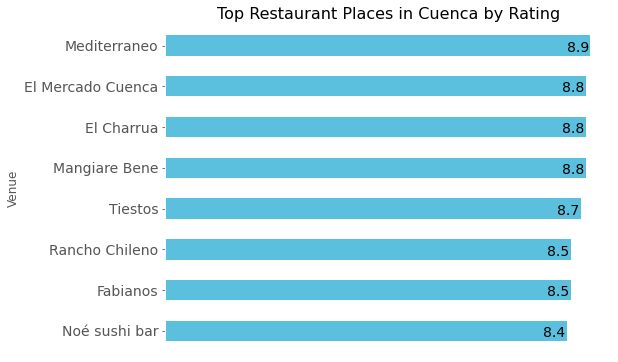

In [37]:
ax = top_placesdf.plot(kind='barh',
                       figsize=(8, 6),
                       color='#5bc0de',
                       width=0.5,
                       fontsize=14
                        )
ax.set_title('Top Restaurant Places in Cuenca by Rating',fontsize=16)
ax.axes.get_xaxis().set_visible(False)
ax.patch.set_facecolor('white')
ax.get_legend().remove()
for b in ax.patches:
    width = b.get_width()
    y = b.get_y()
    ax.annotate(width,(width - 0.5, y + 0.1),fontsize=14)

As we can see, the best place rating in the city of Cuenca is the Mediterranean restaurant, which has a rating of 8.9 according to the Foursquare rating.

[Text(0, 0, 'Mediterraneo'),
 Text(0, 0, 'Noé sushi bar'),
 Text(0, 0, 'Fabianos'),
 Text(0, 0, 'Rancho Chileno'),
 Text(0, 0, 'Tiestos'),
 Text(0, 0, 'Mangiare Bene'),
 Text(0, 0, 'El Charrua'),
 Text(0, 0, 'El Mercado Cuenca'),
 Text(0, 0, 'Mediterraneo'),
 Text(0, 0, '')]

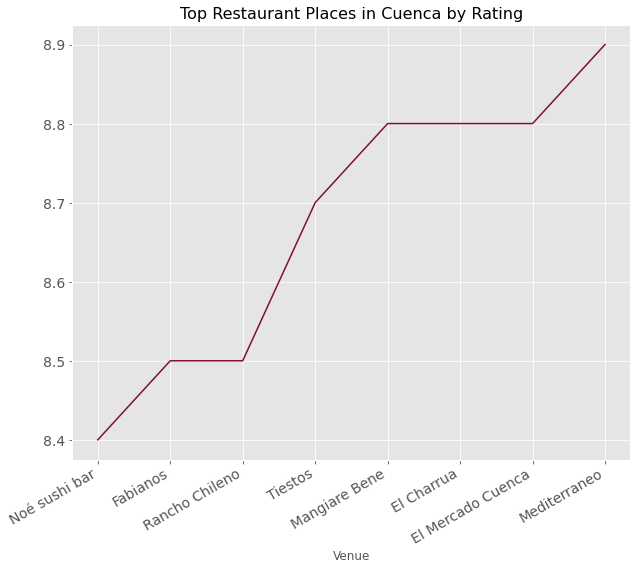

In [38]:
ax1 = top_placesdf.plot(kind='line', 
                        figsize=(10,8),
                        fontsize=14,
                        color='#7f0e36'
                        )
ax1.set_title('Top Restaurant Places in Cuenca by Rating',fontsize=16)
ax1.get_legend().remove()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, ha='right')

We can see that the best rating goes from 8.4 to 8.9, so this is important information for an investor to know the restaurant environment and what type of place will be more accepted in the city.

In [39]:
top_categories=top_placesdf.groupby('Category').count()

Now we create a new data frame, this time with the place categories, to find out which type of top-rated restaurants are the most common.

[Text(0, 0, 'BBQ Joint'),
 Text(0, 0, 'Comfort Food Restaurant'),
 Text(0, 0, 'Italian Restaurant'),
 Text(0, 0, 'Pizza Place'),
 Text(0, 0, 'Restaurant'),
 Text(0, 0, 'South American Restaurant'),
 Text(0, 0, 'Sushi Restaurant')]

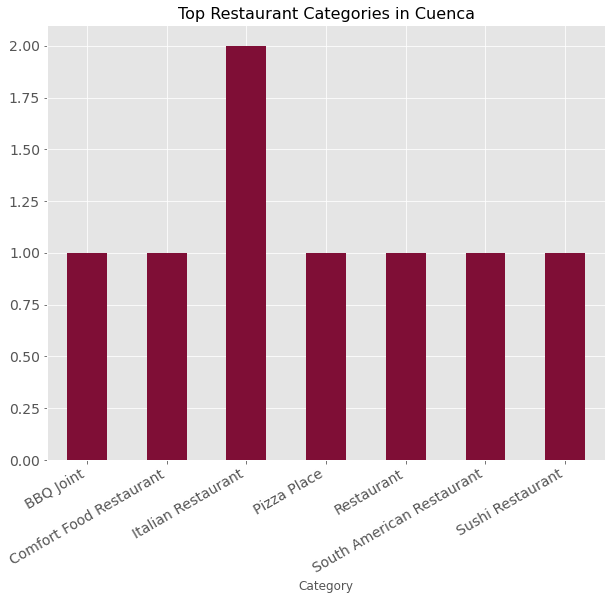

In [40]:
ax1 = top_categories.plot(kind='bar', 
                        figsize=(10,8),
                        fontsize=14,
                        color='#7f0e36'
                        )
ax1.set_title('Top Restaurant Categories in Cuenca',fontsize=16)
ax1.get_legend().remove()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, ha='right')

As we can seee the Italian Restaurant have two places in the most higher rating restaurants in Cuenca, so now we have an idea of what kind of restaurant is the most accepted and best ranking in the city.
With this information, a potential investor can lean his decision on what type of business he invests.